In [1]:
%load_ext autoreload
%autoreload 2

from boolrank import *
from process_data import paths_to_dataset

# dk what this loads
# dataset = load_dataset("data", split="train")
path = "data/{}.jsonl"
pubmed = path.format("training-logs")
# pubmed = path.format("training")
TAR = path.format("TAR_data")
dataset = paths_to_dataset(pubmed, TAR)
bool_key = "bool_query"
nl_key = "nl_query"

print(dataset)
batch_size = 2
epochs = 5 * batch_size
# epochs = 10
lr = 1e-5
decay = 0.01
loss = "clip"
eval_batch = 200

# model = DualSiglip2Model('BAAI/llm-embedder', loss)
model = DualSiglip2Model('BAAI/bge-small-en-v1.5', loss)

model_name = model.model_name.split("/")[-1]
model_path = f"{loss}/{model_name}/b{batch_size}_decay{decay:.0e}"

c:\Users\Simon\miniconda3\envs\RP\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['bool_query', 'source', 'nl_query'],
        num_rows: 3079
    })
    test: {'pubmed-low': Dataset({
        features: ['bool_query', 'source', 'nl_query', '__index_level_0__'],
        num_rows: 84
    }), 'pubmed-medium': Dataset({
        features: ['bool_query', 'source', 'nl_query', '__index_level_0__'],
        num_rows: 259
    }), 'TAR': Dataset({
        features: ['nl_query', 'bool_query', 'source', '__index_level_0__'],
        num_rows: 50
    })}
})


In [2]:
import os
import re
from transformers import Trainer, TrainingArguments
from transformers.utils.notebook import NotebookProgressCallback
from callbacks import NotebookProgressCallbackNoTable, WandbCallbackAveraged
from evaluation import compute_metrics

os.environ["WANDB_PROJECT"] = "Boolean-Ranking"
os.environ["WANDB_LOG_MODEL"] = "false"

# epochs = 10
training_args = TrainingArguments(
    output_dir="models/" + model_path,
    per_device_train_batch_size=batch_size,
    num_train_epochs=epochs,
    learning_rate=lr,
    weight_decay=decay,
    save_steps=1000,
    save_total_limit=1,
    remove_unused_columns=False,
    bf16=True,
    optim="adamw_bnb_8bit",
    logging_steps=100,
    # report_to="wandb",
    eval_steps=200,
    eval_strategy="steps",
    eval_on_start=True,
    per_device_eval_batch_size=eval_batch,
    run_name=model_path,
    # max_steps=1000,
)

def collate_fn(batch):
    d = {
        "in_bool": [ex[bool_key] for ex in batch],
        # "in_text": [re.sub("\[.*?\]", "", ex[nl_key]) for ex in batch],
        "in_text": [ex[nl_key] for ex in batch],
    }
    return d

trainer = Trainer(
    model,
    training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=collate_fn,
    compute_metrics=compute_metrics
)

trainer.remove_callback(NotebookProgressCallback)
trainer.add_callback(NotebookProgressCallbackNoTable)
trainer.add_callback(WandbCallbackAveraged)

trainer.train()
# try: trainer.train(resume_from_checkpoint=True)
# except: trainer.train(resume_from_checkpoint=False)

wandb: Currently logged in as: simon-doehl (simon-doehl-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


TrainOutput(global_step=15400, training_loss=0.3678295739904627, metrics={'train_runtime': 1114.6199, 'train_samples_per_second': 27.624, 'train_steps_per_second': 13.816, 'total_flos': 0.0, 'train_loss': 0.3678295739904627, 'epoch': 10.0})

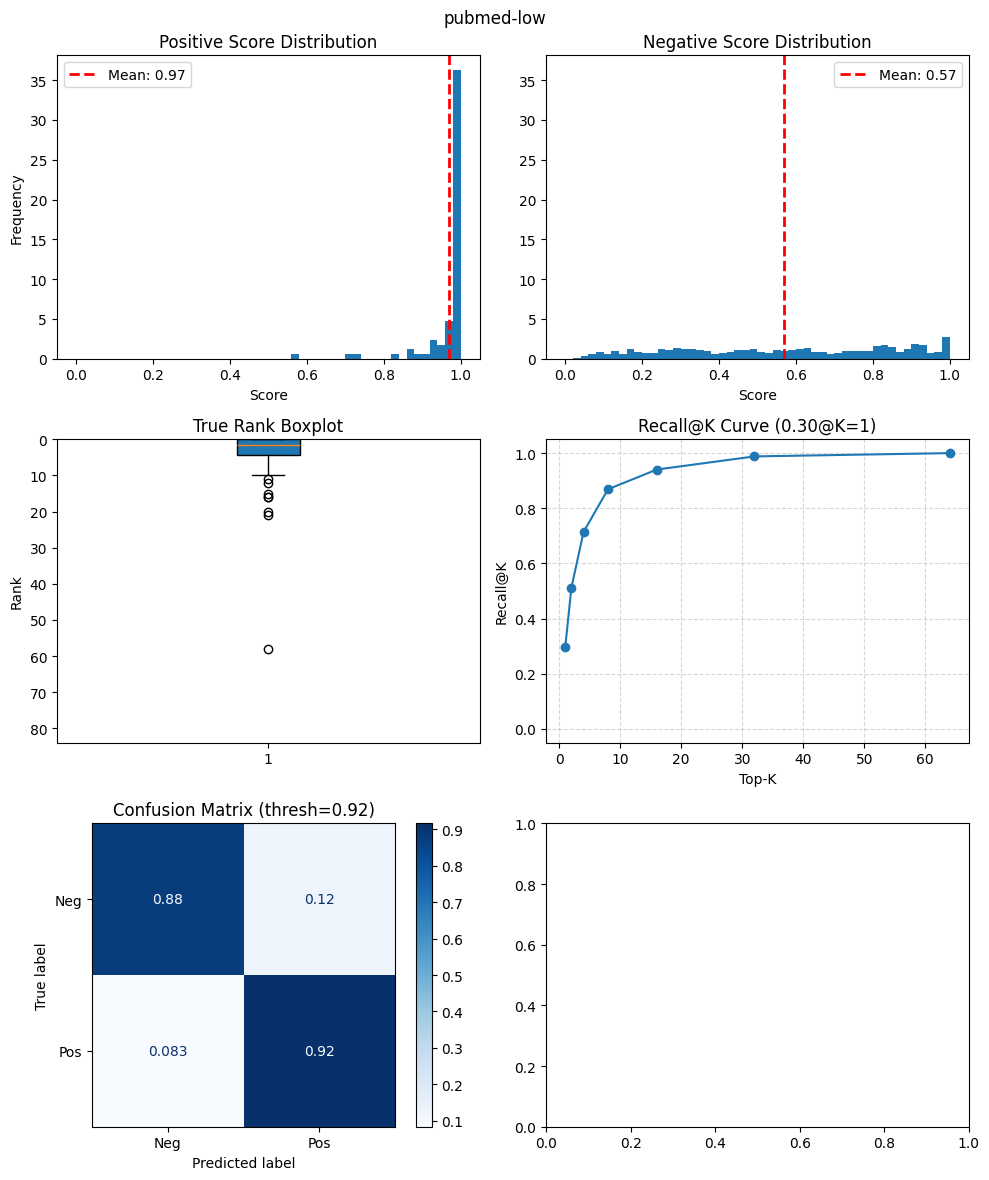

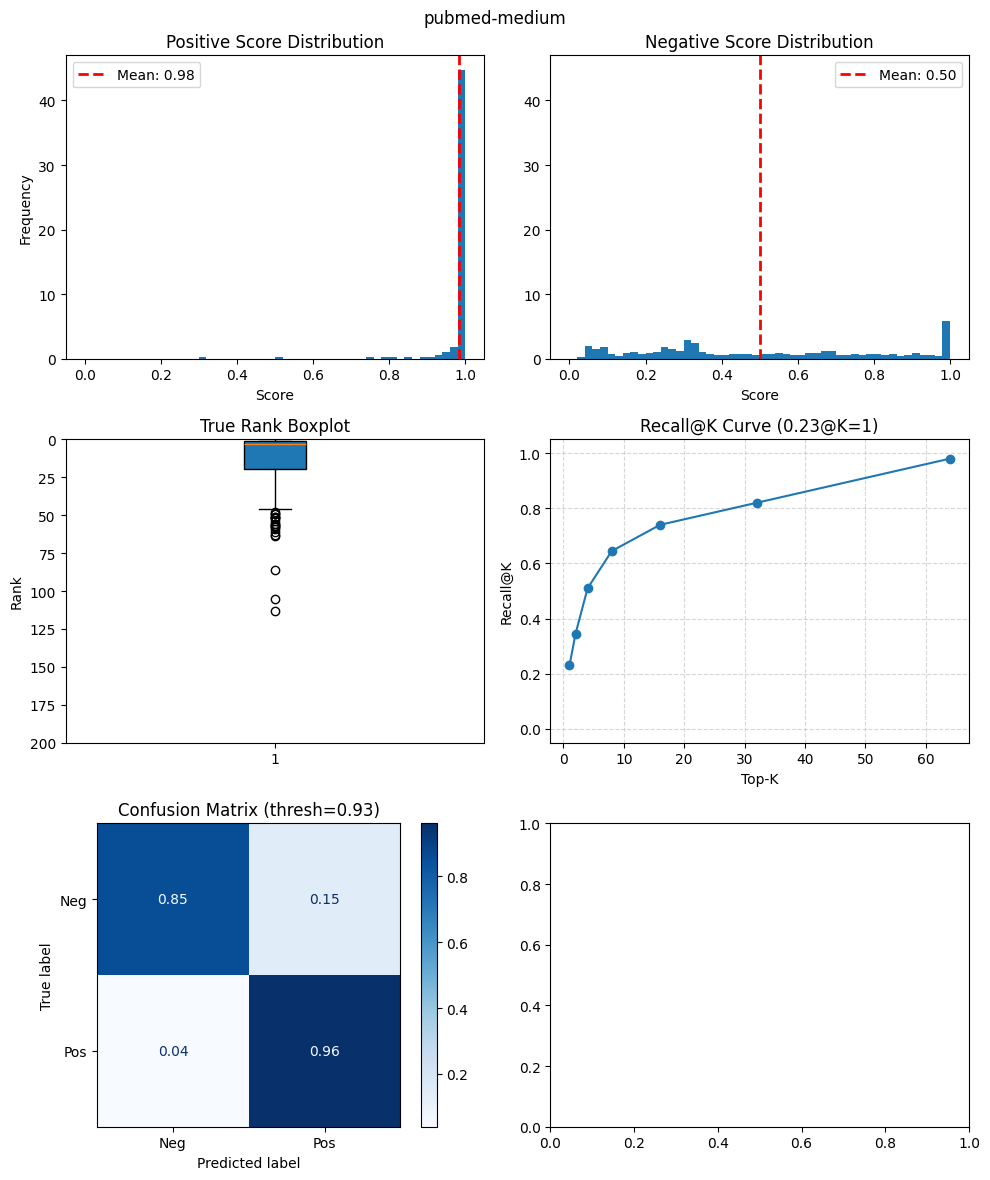

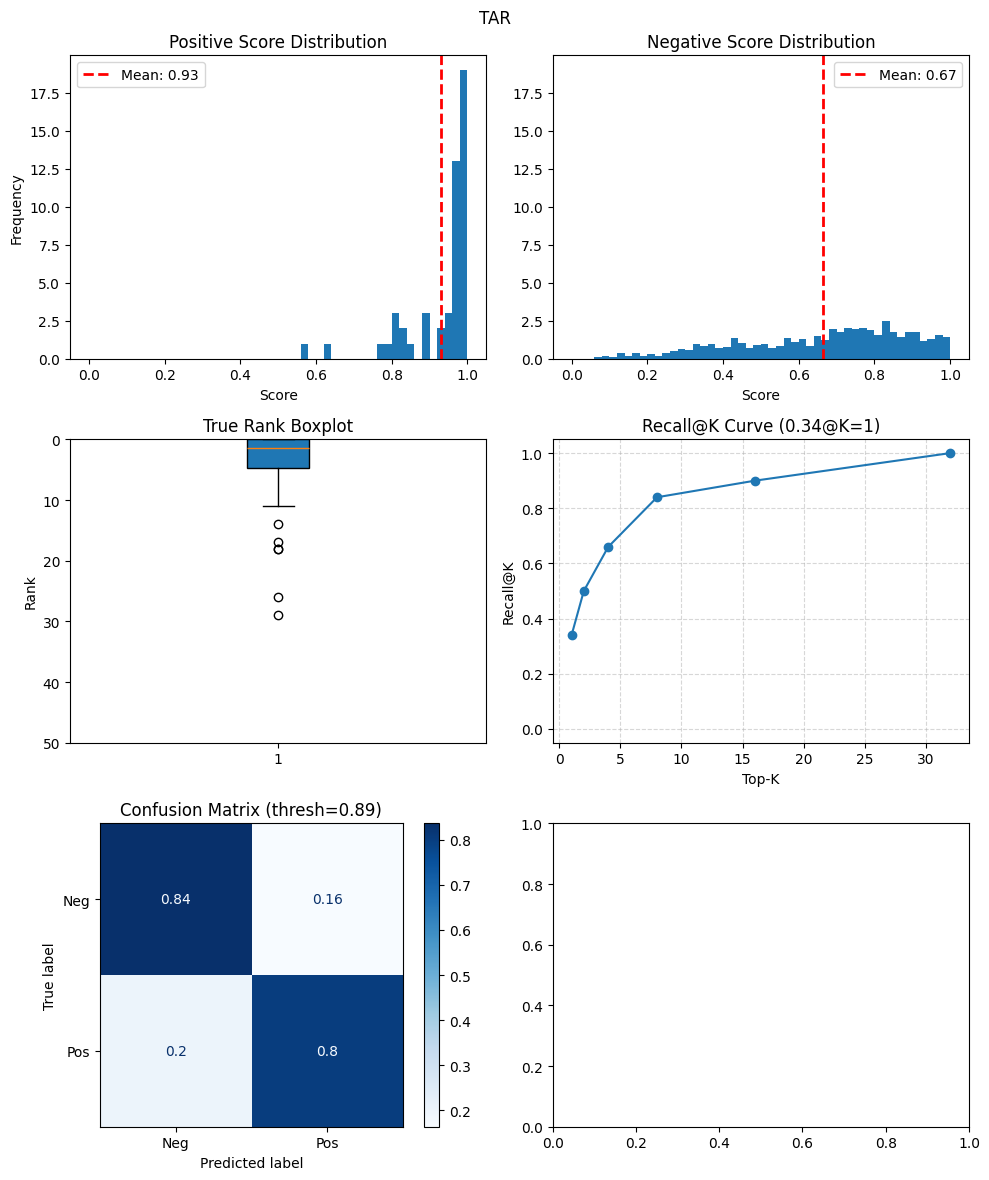

In [3]:
from evaluation import evaluate
# paths = [r"models/siglip2/old/b2-bf-8b/e4", r"models/siglip2/old/b3-bf-8b"]
paths = [None]
amt = eval_batch
format = "pdf"
for path in paths:
    if path is not None:
        model.load(path + "/model.safetensors")
        print(path)
    else: path = model_path

    for key, data in dataset["test"].items():
        res = evaluate(model, data[bool_key][:amt], data[nl_key][:amt], plot=True, title=key)
        res["plot"].savefig(f"models/{path}/test_stats.{format}", format=format)